In [79]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.aqua.components.optimizers import GSLS, L_BFGS_B, SLSQP, TNC, CRS, DIRECT_L, DIRECT_L_RAND, ESCH, ISRES
import math
import random
import numpy as np
from numpy import pi
import time
import itertools
import matplotlib.pyplot as plt
import pickle

## Auxiliary functions

In [97]:
""" save and load results to and from a file """
def save_results_to_disk(obj, name ):
    with open('results/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_results_from_file(name ):
    with open('results/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [98]:
def prepare_initial_state(theta, phase):
    """ Prepare initial state """
    return (math.cos(theta) * (1 + 0j),
        (math.sin(theta) * math.e**(1j * phase) + 0 + 0j))

In [99]:
def convert_counts_to_final_result(counts) -> int:
    """ Convert the execution result to the final measured value: 0 or 1 """
    if "0" in counts:
        return 0
    return 1

In [100]:
def set_random_lambda(lambda0, lambda1):
    """ return a random choice from lambda0 and lambda1 with the correspondent key name """
    lambda_value = random.choice([lambda0, lambda1])
    if lambda_value == lambda0:
        return lambda_value, 0
    return lambda_value, 1

In [101]:
def compute_damping_channel(theta, phase, one_lambda, phi_rx, phi_ry, backend) -> int:
    """ one-time execution of the amplitude damping circuit using the passed parameters 
        Returns: the execution measured result: either 0 or 1
    """
    qreg_q = QuantumRegister(2, 'q')
    creg_c = ClassicalRegister(1, 'c')

    initial_state = prepare_initial_state(theta, phase)

    circuit = QuantumCircuit(qreg_q, creg_c)
    circuit.initialize([initial_state[0],
                        initial_state[1]], qreg_q[0])
    circuit.reset(qreg_q[1])
    circuit.cry(2 * np.arcsin(np.sqrt(one_lambda)), qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[1], qreg_q[0])
    circuit.rx(phi_rx, qreg_q[0])
    circuit.ry(phi_ry, qreg_q[0])
    circuit.measure(qreg_q[0], creg_c[0])

    counts = execute(circuit, backend, shots=1).result().get_counts(circuit)
    return convert_counts_to_final_result(counts)

In [102]:
def compute_random_damping_channel(configuration, backend):
    """ run a one-time execution on the given backend device randomly selectiong the lambda to be used and return the measured result """
    lambda_value, lambda_used = set_random_lambda(configuration['lambda0'], configuration['lambda1'])
    result = compute_damping_channel(configuration['theta'], configuration['phase'], lambda_value, configuration['phi_rx'], configuration['phi_ry'], backend)

    return {
        "result": result,
        "lambda_used": lambda_used
    }

In [103]:
def guess_lambda_used(real_measured_result):
    """ Decides which lambda was used on the real execution.
        It is a silly guess.
        It returns the same lambda used as the measured result
    """
    return real_measured_result

In [104]:
def check_value(real_lambda, guess_lambda): 
    if real_lambda == guess_lambda: return 1
    return 0

In [105]:
def play_and_guess_one_case(configuration, backend):
    """ Execute a real execution with a random lambda from the two passed, 
        guess which one was used on the exection and
        check the result.
        Returns 1 on success (it was a correct guess) or 0 on fail (it was an incorrect guess) 
    """
    real_result = compute_random_damping_channel(configuration, backend)
    guess_lambda = guess_lambda_used(real_result['result'])
    return check_value(real_result['lambda_used'], guess_lambda)

In [106]:
def get_combinations_two_lambdas_without_repeats(input_list_lambda):
    """ from a given list of attenuations (lambdas) create a 
        list of all combinatorial pairs of possible lambdas
        without repeats (order does not matter).
        For us it is the same testing first lambda 0.1 and second lambda 0.2 
        than first lambda 0.2 and second lambda 0.1
    """
    list_lambda = input_list_lambda
     # when there is only one element, we add the same element
    if len(list_lambda) == 1:
        list_lambda.append(list_lambda[0])
    # get combinations of two lambdas without repeats
    return list(itertools.combinations(list_lambda, 2))

## Creating our cost function to be minimized (minimizing the error)

In [107]:
def play_one_configuration(configuration, backend, plays=1000):
    """ Play the play_and_guess game for the number of plays for the configuration of input parameters.
        Returns the average success probability for all the plays with the given configuration. 
    """
    success_counts = 0
    for play in range(plays):
        success_counts += play_and_guess_one_case(configuration, backend)
    return success_counts/plays

In [108]:
def cost_function(params):
    """ Computes the cost of running a specific configuration.
        Cost is computed as 1 (perfect probability) - given probability [0,1]
    """
    backend = backend=Aer.get_backend('qasm_simulator')

    configuration = {
        "theta": params[0],
        "phase": params[1],
        "phi_rx": params[2],
        "phi_ry": params[3],
        "lambda0": GLOBAL_LAMBDA0,
        "lambda1": GLOBAL_LAMBDA1
    }
    return 1 - play_one_configuration(configuration, backend, plays=100)

## Parameter Optimization for the best configuration

In [109]:
def compute_best_configuration( optimizer_algorithms=['CRS'], 
                                list_optimizer_iterations=[1000], 
                                list_step_size=[pi/10], 
                                list_iterations_per_algorithm=[1]):
    """ Find out the best configuration with a global pair of lambdas (channels) trying out a list of specified optimizat algorithm """
    # Create the initial parameters and set the bounds
    initial_params = [0, 0, 0, 0]
    variable_bounds = [
                        (0, pi/2), # theta
                        (0, 2*pi), # phase
                        (0, 2*pi), # rx
                        (0, 2*pi)  # ry
                        ]
    best_probability = 0
    best_configuration = []
    best_optimizer_algorithm = ""

    for optimizer_algorithm, optimizer_iterations, step_size, iterations in zip(optimizer_algorithms, 
                                                                    list_optimizer_iterations, 
                                                                    list_step_size, 
                                                                    list_iterations_per_algorithm):
        print("Analyzing Optimizer Algorithm: ", optimizer_algorithm)
        if optimizer_algorithm == 'GSLS':
            # optimizer = GSLS()
            optimizer = GSLS(maxiter=optimizer_iterations, max_eval=optimizer_iterations, initial_step_size=step_size)
        if optimizer_algorithm == 'L_BFGS_B':
            # optimizer = L_BFGS_B()
            optimizer = L_BFGS_B(maxfun=optimizer_iterations, maxiter=optimizer_iterations, epsilon=step_size)
        if optimizer_algorithm == 'SLSQP':
            # optimizer = SLSQP()
            optimizer = SLSQP(maxiter=optimizer_iterations,  eps=step_size)
        if optimizer_algorithm == 'TNC':
            # optimizer = TNC()
            optimizer = TNC(maxiter=optimizer_iterations, eps=step_size)
        if optimizer_algorithm == 'BOBYQA':
            optimizer = BOBYQA(maxiter=optimizer_iterations)
        if optimizer_algorithm == 'IMFIL':
            optimizer = BOBYQA(maxiter=optimizer_iterations)
        if optimizer_algorithm == 'SNOBFIT':
            optimizer = BOBYQA(maxiter=optimizer_iterations)
        if optimizer_algorithm == 'CRS':
            optimizer = CRS(max_evals=optimizer_iterations)
        if optimizer_algorithm == 'DIRECT_L':
            optimizer = DIRECT_L(max_evals=optimizer_iterations)
        if optimizer_algorithm == 'DIRECT_L_RAND':
            optimizer = DIRECT_L_RAND(max_evals=optimizer_iterations)
        if optimizer_algorithm == 'ESCH':
            optimizer = ESCH(max_evals=optimizer_iterations)
        if optimizer_algorithm == 'ISRES':
            optimizer = ISRES(max_evals=optimizer_iterations)

        
        for i in range(iterations):
            ret = optimizer.optimize(num_vars=len(initial_params), 
                                    objective_function=cost_function, 
                                    variable_bounds=variable_bounds,
                                    initial_point=initial_params)
            print("Best Average Probability:", 1 - ret[1])
            if (1-ret[1]) > best_probability:
                best_probability = 1-ret[1]
                best_configuration = ret[0]
                best_optimizer_algorithm = optimizer_algorithm

    # Print results
    print("Final Best Optimizer Algorithm: ", best_optimizer_algorithm)
    print("Final Best Average Probability:", best_probability)
    print("Parameters Found: " + u"\u03B8" + " = " + str(int(math.degrees(best_configuration[0]))) + u"\u00B0" +
                            ", Phase = " + str(int(math.degrees(best_configuration[1]))) + u"\u00B0" + 
                            ", " + u"\u03D5" + "rx = " + str(int(math.degrees(best_configuration[2]))) + u"\u00B0" + 
                            ", " + u"\u03D5" + "ry = " + str(int(math.degrees(best_configuration[3]))) + u"\u00B0" +
                            ", " + u"\u03BB" + u"\u2080" + " = " + str(GLOBAL_LAMBDA0) + 
                            ", " + u"\u03BB" + u"\u2081" + " = " + str(GLOBAL_LAMBDA1))
    return {
        "best_optimizer_algorithm": best_optimizer_algorithm,
        "best_probability": best_probability,
        "best_configuration": best_configuration
    }


## Find out the best configuration ($\theta, phase, rx, ry$) and success probability for each pair of $\lambda$ attenuation levels from 0 to 1

In [128]:
# create the channels to be used
# from 0 to 1 in steps of 0.1, and adding the 1 as the last value
lambdas = np.append(np.arange(0, 1, 0.5), 1)

optimizer_algorithms = ['TNC']
list_optimizer_iterations=[100]
list_step_size=[pi/10]
list_iterations_per_algorithm=[1]
# optimizer_algorithms = ['CRS', 'DIRECT_L', 'DIRECT_L_RAND', 'ESCH', 'ISRES']
# list_optimizer_iterations=[1000, 1000, 1000, 1000, 1000]
# list_step_size=[pi/10, pi/10, pi/10, pi/10, pi/10]
# list_iterations_per_algorithm=[1, 1, 1, 1, 1]
# optimizer_algorithms = ['GSLS', 'L_BFGS_B', 'SLSQP', 'TNC']
# list_optimizer_iterations=[10000, 1000, 100, 100]
# list_step_size=[pi/10, pi/10, pi/10, pi/10]
# list_iterations_per_algorithm=[1, 1, 1, 1]
two_pair_lambdas = get_combinations_two_lambdas_without_repeats(lambdas)
probabilities = []
configurations = []
best_algorithm = []

program_start_time = time.time()
print("Starting the execution")

for lambda_pair in two_pair_lambdas:
    start_time = time.time()
    GLOBAL_LAMBDA0=lambda_pair[0]
    GLOBAL_LAMBDA1=lambda_pair[1]
    result = compute_best_configuration(optimizer_algorithms=optimizer_algorithms,
                                        list_optimizer_iterations=list_optimizer_iterations,
                                        list_step_size=list_step_size, 
                                        list_iterations_per_algorithm=list_iterations_per_algorithm)
    probabilities.append(result['best_probability'])
    configurations.append(result['best_configuration'])
    best_algorithm.append(result['best_optimizer_algorithm'])
    end_time = time.time()
    print("total minutes taken this pair of lambdas: ", int(np.round((end_time - start_time)/60)))
    print("total minutes taken so far: ", int(np.round((end_time - program_start_time)/60)))

end_time = time.time()
print("total minutes of execution time: ", int(np.round((end_time - program_start_time)/60)))
print("All guesses have been calculated")
print(f'Total pair of lambdas tested: {len(lambda_pairs)}')

result = {
    "lambda_pairs": two_pair_lambdas,
    "best_algorithm": best_algorithm,
    "probabilities": probabilities,
    "configurations": configurations
}

Starting the execution
Analyzing Optimizer Algorithm:  TNC
Best Average Probability: 0.52
Final Best Optimizer Algorithm:  TNC
Final Best Average Probability: 0.52
Parameters Found: θ = 0°, Phase = 0°, ϕrx = 0°, ϕry = 0°, λ₀ = 0.0, λ₁ = 0.5
total minutes taken this pair of lambdas:  1
total minutes taken so far:  1
Analyzing Optimizer Algorithm:  TNC
Best Average Probability: 0.54
Final Best Optimizer Algorithm:  TNC
Final Best Average Probability: 0.54
Parameters Found: θ = 0°, Phase = 23°, ϕrx = 0°, ϕry = 71°, λ₀ = 0.0, λ₁ = 1.0
total minutes taken this pair of lambdas:  3
total minutes taken so far:  3
Analyzing Optimizer Algorithm:  TNC
Best Average Probability: 0.47
Final Best Optimizer Algorithm:  TNC
Final Best Average Probability: 0.47
Parameters Found: θ = 0°, Phase = 136°, ϕrx = 68°, ϕry = 68°, λ₀ = 0.5, λ₁ = 1.0
total minutes taken this pair of lambdas:  3
total minutes taken so far:  6
total minutes of execution time:  6
All guesses have been calculated
Total pair of lambda

In [129]:
result

{'lambda_pairs': [(0.0, 0.5), (0.0, 1.0), (0.5, 1.0)],
 'best_algorithm': ['TNC', 'TNC', 'TNC'],
 'probabilities': [0.52, 0.54, 0.47],
 'configurations': [array([1.00449408e-08, 7.69636615e-07, 1.22306798e-06, 3.09691683e-07]),
  array([0.        , 0.41584817, 0.        , 1.24754451]),
  array([0.        , 2.38160744, 1.19080372, 1.19080372])]}

In [82]:
""" Save results to disk """
# save_results_to_disk(result, name='20210320_results_CRS')

In [83]:
""" Load results from a file """
# loaded_results = load_results_from_file(name='20210320_results_CRS')


## Plotting the results

In [134]:
def plot_scatter(results, option):
    X = []
    Y = []
    x_label = "$\lambda$ Pairs"
    
    if option == 'probabilities':
        title = "Success Probability for each $\lambda$ pair"
        Y = results['probabilities']
        for lambda_pair in results['lambda_pairs']:
            X.append(str(lambda_pair[0]) + ' ' + str(lambda_pair[1]))
        y_label = "Success Probability"
    if option == "input State":
        title = "Input State for each $\lambda$ pair" 
        for lambda_pair,configuration in zip(results['lambda_pairs'],results['configurations']):
            X.append(str(lambda_pair[0]) + ' ' + str(lambda_pair[1]))
            Y.append(str(int(math.degrees(configuration[0]))) + ' ' + str(int(math.degrees(configuration[1]))))
        y_label = "Input States"
    if option == "measurement angles":
        title = "Measurement angles for each $\lambda$ pair" 
        for lambda_pair,configuration in zip(results['lambda_pairs'],results['configurations']):
            X.append(str(lambda_pair[0]) + ' ' + str(lambda_pair[1]))
            Y.append(str(int(math.degrees(configuration[2]))) + ' ' + str(int(math.degrees(configuration[3]))))
        y_label = "Measurement angles"
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(title, fontsize=20)
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.scatter(X, Y)
    plt.show()

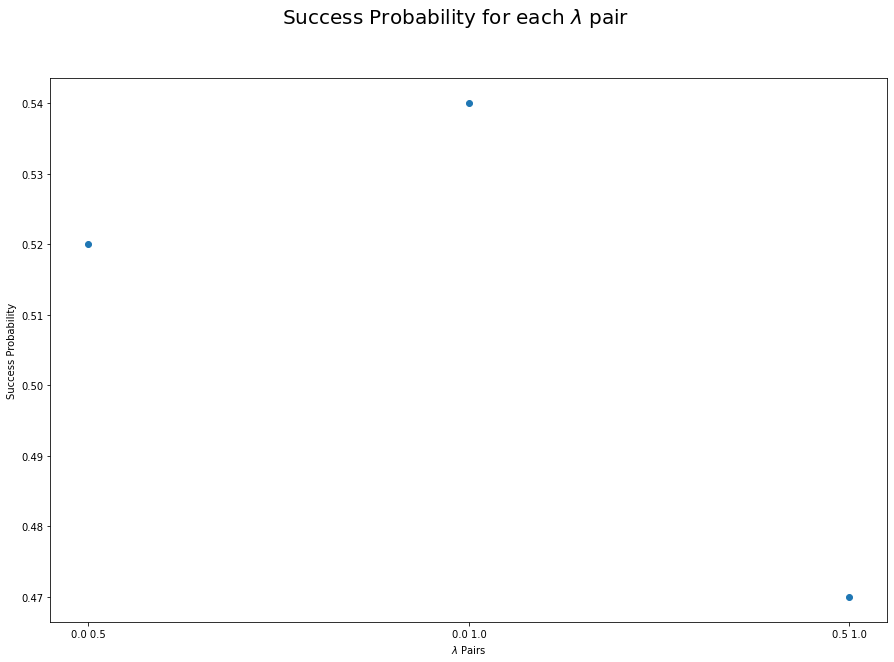

In [135]:
plot_scatter(result, option='probabilities')

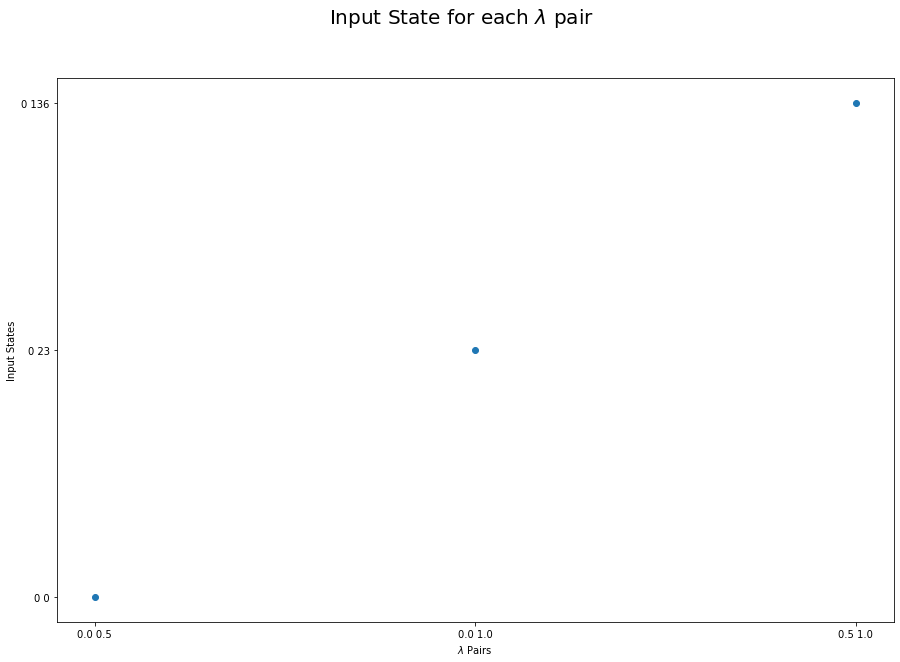

In [136]:
plot_scatter(result, option='input State')

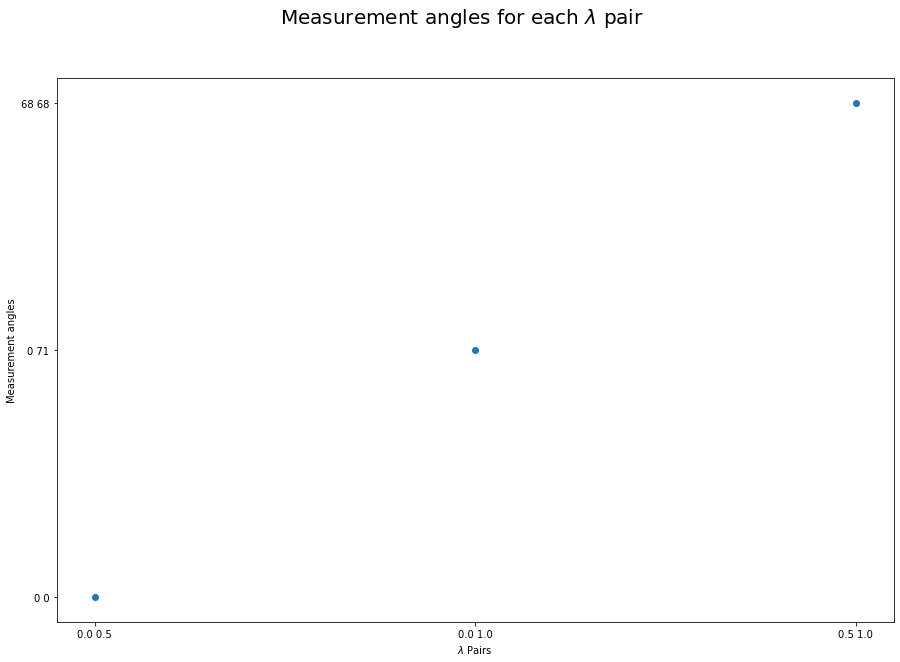

In [137]:
plot_scatter(result, option="measurement angles")